In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit import Aer
from squlearn import Executor
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam, SPSA
from squlearn.observables import SummedPaulis, CustomObservable
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam
from squlearn import Executor


from qiskit.circuit.library import TwoLocal
from squlearn.encoding_circuit import *

algorithm_globals.random_seed = 42



In [60]:

# Function to read and process data from the input format
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    features = []
    labels = []

    i = 0
    while i < 20:
        num_atoms = int(lines[i])
        energy = float(lines[i + 1].split()[-1])
        label = np.array([energy])

        atom_data = [line.split() for line in lines[i + 2:i + 2 + num_atoms]]
        coordinates = np.array([[float(coord) for coord in atom[1:]] for atom in atom_data])

        features.append(coordinates.flatten())
        labels.append(label)

        i += 2 + num_atoms

    return np.array(features), np.array(labels)


# Read data from the provided file
file_path = 'water-DZ-F12-STATIC-g32n10-3M_PES-DZERO.xyz'
features, labels = read_data(file_path)
print(features[:3], labels[:3])
print(len(features), len(labels))

[[ 0.0089378   0.          0.43550962 -0.79730093  0.         -0.59766049
   0.6554516   0.         -0.48758562]
 [ 0.00715024  0.          0.43550962 -0.78311599  0.         -0.586653
   0.66963653  0.         -0.49859311]
 [-0.02323827  0.          0.43812567 -0.57271362  0.         -0.42028506
   0.94152185  0.         -0.70647973]] [[-76.27315556]
 [-76.27389312]
 [-76.2506881 ]]
4 4


In [61]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

features = MinMaxScaler().fit_transform(features)

train_labelm = np.mean(labels)
train_labelstd = np.std(labels)

print("Mean = ", train_labelm, "Std =", train_labelstd)

transformed_labels = (labels - train_labelm) / train_labelstd
print(len(transformed_labels))
print(transformed_labels[1])
print(features[1])

test_size=0.2
train_features, test_features, train_labels, test_labels = train_test_split(
    features, transformed_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


Mean =  -76.2608322035 Std = 0.01282203253352806
4
[-1.01863082]
[0.58620691 0.         0.         0.44721373 0.         0.44257462
 0.38502024 0.         0.61147356]


In [28]:
executor = Executor("statevector_simulator")

ising_op = IsingHamiltonian(9, I="S", Z="S", ZZ="S")
print(ising_op)
observable_list = ["IIIIIIIII","IIZIIIIII","IZIIIIIII","ZIIIIIIII"]

observable  = CustomObservable(num_qubits=9, operator_string=observable_list, parameterized=True)
print(observable)

SparsePauliOp(['IIIIIIIII', 'IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIIZZI', 'IIIIIZIIZ', 'IIIIIZIZI', 'IIIIIZZII', 'IIIIZIIIZ', 'IIIIZIIZI', 'IIIIZIZII', 'IIIIZZIII', 'IIIZIIIIZ', 'IIIZIIIZI', 'IIIZIIZII', 'IIIZIZIII', 'IIIZZIIII', 'IIZIIIIIZ', 'IIZIIIIZI', 'IIZIIIZII', 'IIZIIZIII', 'IIZIZIIII', 'IIZZIIIII', 'IZIIIIIIZ', 'IZIIIIIZI', 'IZIIIIZII', 'IZIIIZIII', 'IZIIZIIII', 'IZIZIIIII', 'IZZIIIIII', 'ZIIIIIIIZ', 'ZIIIIIIZI', 'ZIIIIIZII', 'ZIIIIZIII', 'ZIIIZIIII', 'ZIIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpressio

In [5]:
def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

c:\Python\Python3.9.2\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


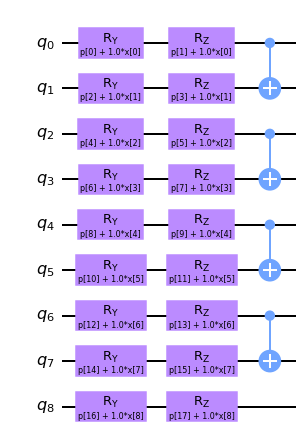

In [29]:
enc_circ = YZ_CX_EncodingCircuit(9, num_features=9, num_layers=1)
enc_circ.draw("mpl")

In [32]:
""" np.random.seed(13)
param_ini = np.random.rand(enc_circ.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters) """

qnn = QNNRegressor(enc_circ, ising_op, executor, SquaredLoss(), Adam(
    options={"maxiter":5}
), callback=callback_graph,  variance=0.0005,)

In [8]:
""" reg = QNNRegressor(enc_circ, ising_op, executor, SquaredLoss(), Adam(), param_ini, param_op_ini, callback=callback_graph) """

' reg = QNNRegressor(enc_circ, ising_op, executor, SquaredLoss(), Adam(), param_ini, param_op_ini, callback=callback_graph) '

In [50]:
print(train_features, train_labels)

[[1.         0.         0.         0.         0.         0.
  0.         0.         1.        ]
 [0.62068968 0.         0.         0.40994591 0.         0.40569341
  0.35293523 0.         0.64385076]
 [0.         0.         1.         1.         0.         1.
  1.         0.         0.        ]] [[ 1.18859194]
 [-0.96110757]
 [ 0.79114645]]


In [67]:
train_labels = np.array([i[0] for i in train_labels])
print(train_labels)

[ 1.18859194 -0.96110757  0.79114645]


c:\Python\Python3.9.2\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


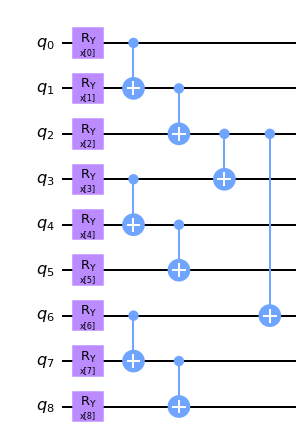

In [62]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector

# Create a list of 9 Parameter objects for the 9 qubits
#parameters = [Parameter(f'x{i}') for i in range(9)]
parameters = ParameterVector('x', length=9)
# Initialize the quantum circuit
feature_map = QuantumCircuit(9)

# Apply rotation gates with parameters to encode atom positions
for i, param in enumerate(parameters):
    feature_map.ry(param, i)
    

# Apply intra-group entanglement for each atom
for i in range(0, 9, 3):
    feature_map.cx(i, i+1)
    feature_map.cx(i+1, i+2)

feature_map.cx(2, 3)

feature_map.cx(2, 6)

feature_map.draw("mpl")



In [63]:
from squlearn.encoding_circuit import QiskitEncodingCircuit

circuit = QiskitEncodingCircuit(feature_map)

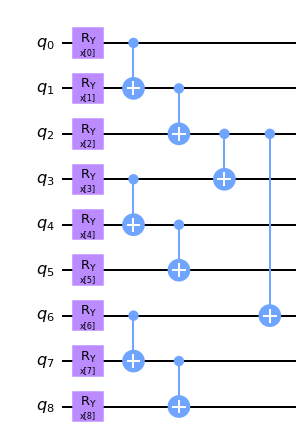

In [64]:
circuit.draw("mpl")

In [68]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam, SPSA

executor = Executor("statevector_simulator")

nqubits = 9
number_of_layers = 1

pqc = ChebyshevRx(nqubits, 9, num_layers=number_of_layers)
pqc.draw("mpl")

ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(circuit, ising_op, executor, SquaredLoss(), SLSQP())

x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)


reg.fit(train_features, train_labels)
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

SparsePauliOp(['IIIIIIIII', 'IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIIZZI', 'IIIIIZIIZ', 'IIIIIZIZI', 'IIIIIZZII', 'IIIIZIIIZ', 'IIIIZIIZI', 'IIIIZIZII', 'IIIIZZIII', 'IIIZIIIIZ', 'IIIZIIIZI', 'IIIZIIZII', 'IIIZIZIII', 'IIIZZIIII', 'IIZIIIIIZ', 'IIZIIIIZI', 'IIZIIIZII', 'IIZIIZIII', 'IIZIZIIII', 'IIZZIIIII', 'IZIIIIIIZ', 'IZIIIIIZI', 'IZIIIIZII', 'IZIIIZIII', 'IZIIZIIII', 'IZIZIIIII', 'IZZIIIIII', 'ZIIIIIIIZ', 'ZIIIIIIZI', 'ZIIIIIZII', 'ZIIIIZIII', 'ZIIIZIIII', 'ZIIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpressio

In [33]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor

qnn.fit(train_features, train_labels)

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.